In [1]:
import pandas as pd
import seaborn as sns

# %%
df = pd.DataFrame(columns=["Cipher", "Mode", "CPU", "Length", "Speed"])


# %%
def addfile_2(cpu, filename, cipher, dftmp):
    with open(filename, "r", encoding="utf8", errors='ignore') as f:
        lines = f.readlines()
        for line in lines:
            if "---" in line:
                line = line.replace("-", '').replace("(Gbps)", "")
                mode = line.replace("speed test", "").strip()
                if "GCM" in mode:
                    mode = "AEAD"
            elif "length" in line:
                length, speed = line.split(',')[:2]
                length = int(length.split(":")[1])
                speed = float(speed.split(":")[1])
                dftmp = pd.concat([dftmp, pd.DataFrame([[cipher, mode, cpu, length, speed]], columns=dftmp.columns)], ignore_index=True)
    return dftmp

def addfile_3(cpu, filename, dftmp):
    with open(filename, "r", encoding="utf8", errors='ignore') as f:
        lines = f.readlines()
        for i in range(len(lines)):
            if "type" in lines[i] and "bytes" in lines[i]:
                #type           8192 bytes
                length = int(lines[i].split()[1])
                speed = float(lines[i+1].split()[1][:-2]) / 1000 / 1000 * 8
                cipher = lines[i+1].split()[0].upper()
                if "GCM" in cipher:
                    mode = "AEAD"
                else:
                    mode = "Encryption Only"
                dftmp = pd.concat([dftmp, pd.DataFrame([[cipher, mode, cpu, length, speed]], columns=dftmp.columns)], ignore_index=True)
    return dftmp

def addfile_4(cpu, filename, dftmp):
    with open(filename, "r", encoding="utf8", errors='ignore') as f:
        lines = f.readlines()
        for line in lines:
            if "===" in line:
                cipher = line.replace("=", "").replace("test", "").strip()
            if "---" in line:
                line = line.replace("-", '').replace("(Gbps)", "")
                mode = line.replace("speed test", "").strip()
                if "GCM" in mode:
                    mode = "AEAD"
            elif "length" in line:
                length, speed = line.split(',')[:2]
                length = int(length.split(":")[1])
                speed = float(speed.split(":")[1])  
                dftmp = pd.concat([dftmp, pd.DataFrame([[cipher, mode, cpu, length, speed]], columns=dftmp.columns)], ignore_index=True)
    return dftmp


In [3]:
Devices_dir = ["M3Pro", "M4", "W3495", "Icelake", "EPYC9334", "7950X", "6242R", "E5-2620v3", "12800HX", "13900HX", "13980HX"]
Devices = ["Apple M3 Pro", "Apple M4", "Intel Xeon W9-3495X", "Intel Xeon Gold 6326", "AMD EPYC 9334", "AMD Ryzen 9 7950X", "Intel Xeon Gold 6242R", "Intel Xeon E5-2620v3", "Intel Core i7-12800HX", "Intel Core i9-13900HX", "Intel Core i9-13980HX"]
df = pd.DataFrame(columns=["Cipher", "Mode", "CPU", "Length", "Speed"])
for device_id in range(len(Devices)):
    device = Devices[device_id]
    device_dir = Devices_dir[device_id]
    df = addfile_4(device, f"{device_dir}/bench_log", df)
    df = addfile_3(device, f"{device_dir}/AES_log", df)
df


,Cipher,Mode,CPU,Length,Speed
0,HiAE,Encryption Only,Apple M3 Pro,16,10.190000
1,HiAE,Encryption Only,Apple M3 Pro,64,20.400000
2,HiAE,Encryption Only,Apple M3 Pro,256,83.730000
3,HiAE,Encryption Only,Apple M3 Pro,512,116.710000
4,HiAE,Encryption Only,Apple M3 Pro,1024,144.670000
...,...,...,...,...,...
48135,AES-256-GCM,AEAD,Intel Core i9-13980HX,1024,59.317631
48136,AES-256-CTR,Encryption Only,Intel Core i9-13980HX,256,62.327374
48137,AES-256-GCM,AEAD,Intel Core i9-13980HX,256,43.847869
48138,AES-256-CTR,Encryption Only,Intel Core i9-13980HX,64,32.998086


In [4]:
df = df[df["Length"] != 16]
df

,Cipher,Mode,CPU,Length,Speed
1,HiAE,Encryption Only,Apple M3 Pro,64,20.400000
2,HiAE,Encryption Only,Apple M3 Pro,256,83.730000
3,HiAE,Encryption Only,Apple M3 Pro,512,116.710000
4,HiAE,Encryption Only,Apple M3 Pro,1024,144.670000
5,HiAE,Encryption Only,Apple M3 Pro,2048,169.070000
...,...,...,...,...,...
48135,AES-256-GCM,AEAD,Intel Core i9-13980HX,1024,59.317631
48136,AES-256-CTR,Encryption Only,Intel Core i9-13980HX,256,62.327374
48137,AES-256-GCM,AEAD,Intel Core i9-13980HX,256,43.847869
48138,AES-256-CTR,Encryption Only,Intel Core i9-13980HX,64,32.998086


In [ ]:
df.to_csv("logs.csv", index=False)
#对每一类去掉最大最小值进行平均
for CPU in df["CPU"].unique():
    for cipher in df["Cipher"].unique():
        for mode in df["Mode"].unique():
            for length in df["Length"].unique():
                for _ in range(5):
                    #df_tmp = df[(df["CPU"] == CPU) & (df["Cipher"] == cipher) & (df["Mode"] == mode) & (df["Length"] == length)]
                    if len(df[(df["CPU"] == CPU) & (df["Cipher"] == cipher) & (df["Mode"] == mode) & (df["Length"] == length)]) > 20:
                        df = df.drop(df[(df["CPU"] == CPU) & (df["Cipher"] == cipher) & (df["Mode"] == mode) & (df["Length"] == length)]["Speed"].idxmin())
                        df = df.drop(df[(df["CPU"] == CPU) & (df["Cipher"] == cipher) & (df["Mode"] == mode) & (df["Length"] == length)]["Speed"].idxmax())
df
df_avg = df.groupby(['Cipher', 'Mode', 'CPU', 'Length']).mean().reset_index()
df_avg.to_csv("logs_avg.csv", index=False)
df_avg

SyntaxError: invalid syntax (135760371.py, line 12)

Text(0.5, 1.0, 'Benchmark on Apple M3 Pro')

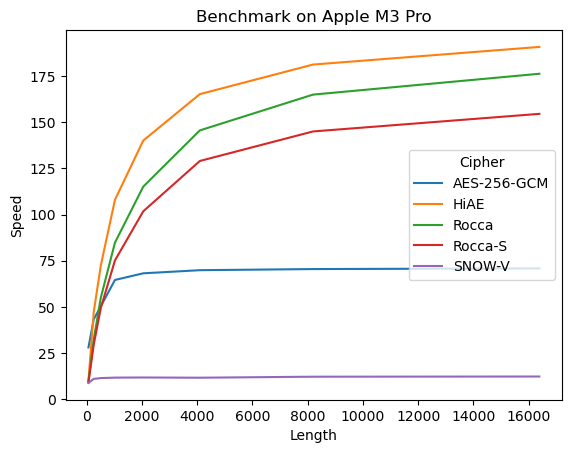

In [25]:
CPU_name = "Apple M3 Pro"
Mode_name = 'AEAD'
import matplotlib.pyplot as plt
sns.lineplot(data=df_avg[(df_avg['CPU'] == CPU_name) & (df_avg['Mode'] == Mode_name)& (df_avg['Length'] < 17000) & (df_avg['Length'] >=64)], x='Length', y='Speed', hue="Cipher", palette="tab10")
plt.title("Benchmark on " + CPU_name)

In [26]:
#Devices = ["Apple M1", "Apple M2 Max", "Apple M3 Pro", "AMD EPYC 9334", "Intel Xeon Gold 6326", 
#          "Intel Xeon Gold 6230", "Intel Xeon Silver 4108", "Intel Xeon E5-2620 v3", "AMD EPYC 7763",
#            "AMD Ryzen 9 7950X", "Intel Core i9-13980HX"]
ciphers_name = ["HiAE", "Rocca", "Rocca-S", "AEGIS", "SNOW-V", "AES-256"]
for device in Devices:
    print("\\multicolumn{16}{|c|}{\\textbf{" + device + "}}\\\\\n\\hline")
    for cipher in ciphers_name:
        s = ""
        for mode in ["Encryption Only", "AEAD"]:
            if cipher == "SNOW-V":
                if mode == "AEAD":
                    s += f"& SNOW-V-GCM "
                else:
                    s += f"& SNOW-V "
            elif cipher == "AEGIS":
                s += f"& AEGIS-128L "
            elif cipher == "HiAE":
                s += f"& HiAE (this work) "
            elif "AES-256" in cipher:
                if mode == "AEAD":
                    cipher = "AES-256-GCM"
                else:
                    cipher = "AES-256-CTR"
                s += f"& {cipher} "
            else:
                s += f"& {cipher} "
        
            for lens in [16384, 8192, 4096, 2048, 1024, 256, 64]:
                speed_value = df_avg.loc[(df_avg["Cipher"] == cipher) & (df_avg["Mode"] == mode) & (df_avg["Length"] == lens) & (df_avg["CPU"] == device), "Speed"].values
                if len(speed_value) > 0:
                    if speed_value[0] == max(df_avg.loc[(df_avg["Mode"] == mode) & (df_avg["Length"] == lens) & (df_avg["CPU"] == device), "Speed"].values):
                        s += " & \\textbf{" f"{speed_value[0]:.2f}" + "} "
                        #s += f" & {speed_value[0]:.2f} "
                    else:
                        s += f" & {speed_value[0]:.2f} "
                else:
                    s += " & N/A "
        print(s[1:] + "\\\\")
    print("\\hline")

\multicolumn{16}{|c|}{\textbf{Apple M3 Pro}}\\
\hline
 HiAE (this work)  & \textbf{195.56}  & \textbf{190.66}  & \textbf{181.45}  & \textbf{165.47}  & \textbf{140.63}  & \textbf{77.94}  & 19.24 & HiAE (this work)  & \textbf{190.89}  & \textbf{181.33}  & \textbf{165.31}  & \textbf{140.15}  & \textbf{108.04}  & \textbf{47.28}  & 9.89 \\
 Rocca  & 182.93  & 176.54  & 165.42  & 146.00  & 119.01  & 57.40  & 19.63 & Rocca  & 176.34  & 165.04  & 145.65  & 115.18  & 84.84  & 32.41  & 9.70 \\
 Rocca-S  & 160.17  & 154.60  & 145.42  & 128.65  & 106.48  & 52.34  & 19.57 & Rocca-S  & 154.61  & 145.07  & 129.08  & 101.79  & 75.19  & 29.56  & 9.01 \\
 AEGIS-128L  & N/A  & N/A  & N/A  & N/A  & N/A  & N/A  & N/A & AEGIS-128L  & N/A  & N/A  & N/A  & N/A  & N/A  & N/A  & N/A \\
 SNOW-V  & 37.22  & 36.24  & 34.57  & 31.39  & 26.74  & 13.78  & 4.66 & SNOW-V-GCM  & 12.24  & 12.14  & 11.60  & 11.72  & 11.65  & 10.97  & 8.77 \\
 AES-256-CTR  & 104.51  & 103.49  & 101.20  & 99.68  & 93.52  & 69.57  & \textbf{